# U-Net to Diffusion



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## Dataset



In [4]:
train_set = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
NUM_CLASSES = 10

100%|██████████| 26421880/26421880 [00:01<00:00, 13719735.53it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 325094.16it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6046051.05it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 34164995.24it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



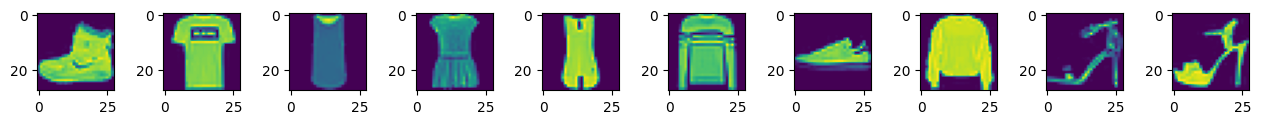

In [5]:
plt.figure(figsize=(16, 1))

def show_images(dataset, num_samples=10):
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

show_images(train_set)

In [6]:
IMG_SIZE = 16 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 1 # Black and white image, no color channels
BATCH_SIZE = 128

In [7]:
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )

def load_transformed_fashionMNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    return torch.utils.data.ConcatDataset([train_set, test_set])

In [8]:
data = load_transformed_fashionMNIST()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13277153.18it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 327989.94it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6084511.03it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26014791.56it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## U-Net Architecture

In [9]:
class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        kernel_size = 3
        stride = 1
        padding = 1

        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [10]:
ch, h, w = 1, 3, 3
x = torch.ones(1, ch, h, w)
x

tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

In [22]:
kernel = torch.tensor([[1.]])  # Identity kernel
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # Make into a batch

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

In [21]:
kernel_size = 4
kernel = torch.ones(1, 1, kernel_size, kernel_size)

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]
output

tensor([[[1., 2., 3., 3., 2., 1.],
         [2., 4., 6., 6., 4., 2.],
         [3., 6., 9., 9., 6., 3.],
         [3., 6., 9., 9., 6., 3.],
         [2., 4., 6., 6., 4., 2.],
         [1., 2., 3., 3., 2., 1.]]])

In [23]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # Convolution variables
        kernel_size = 3
        stride = 1
        padding = 1

        # Transpose variables
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs for concatednated skip connection
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        ]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [24]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH
        down_chs = (16, 32, 64)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1),
        )

    def forward(self, x):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0, down2)
        up2 = self.up2(up1, down1)
        return self.out(up2)

In [25]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  234977


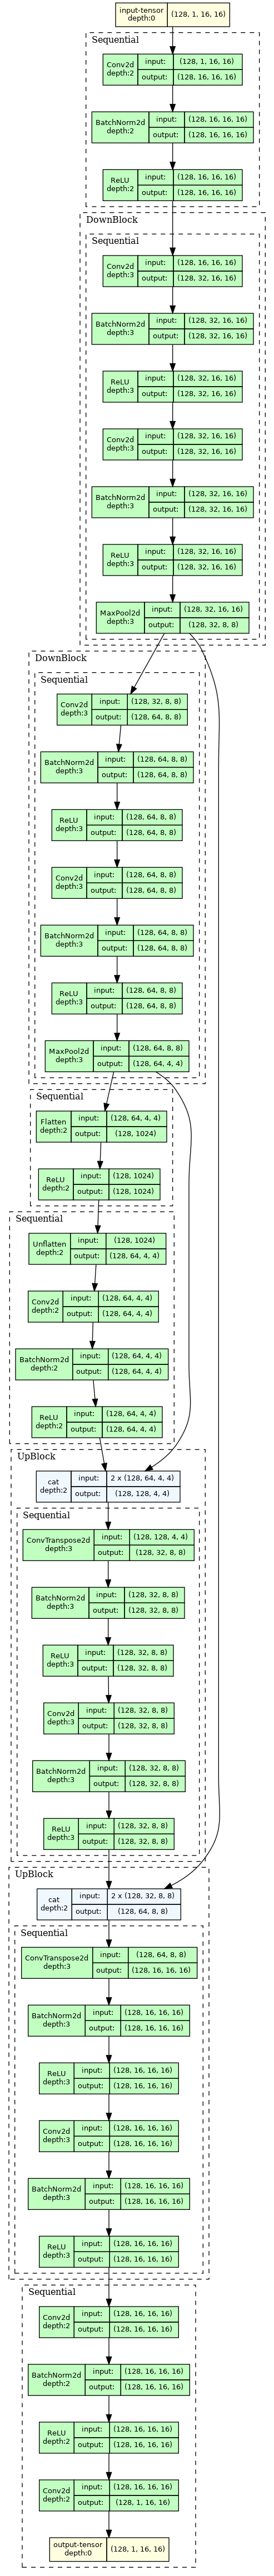

In [26]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(
    model,
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE),
    device='meta',
    expand_nested=True
)
model_graph.resize_graph(scale=1.5)
model_graph.visual_graph

In [27]:
model = torch.compile(UNet().to(device))

## Training

In [28]:
def add_noise(imgs):
    dev = imgs.device
    percent = .5 # Try changing from 0 to 1
    beta = torch.tensor(percent, device=dev)
    alpha = torch.tensor(1 - percent, device=dev)
    noise = torch.randn_like(imgs)
    return alpha * imgs + beta * noise

In [29]:
def get_loss(model, imgs):
    imgs_noisy = add_noise(imgs)
    imgs_pred = model(imgs_noisy)
    return F.mse_loss(imgs, imgs_pred)

In [30]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [31]:
@torch.no_grad()
def plot_sample(imgs):
    # Take first image of batch
    imgs = imgs[[0], :, :, :]
    imgs_noisy = add_noise(imgs[[0], :, :, :])
    imgs_pred = model(imgs_noisy)

    nrows = 1
    ncols = 3
    samples = {
        "Original" : imgs,
        "Noise Added" : imgs_noisy,
        "Predicted Original" : imgs_pred
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

Epoch 0 | Step 000 Loss: 0.5985658168792725 


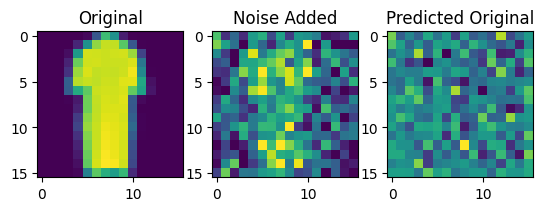

Epoch 0 | Step 100 Loss: 0.10297694057226181 


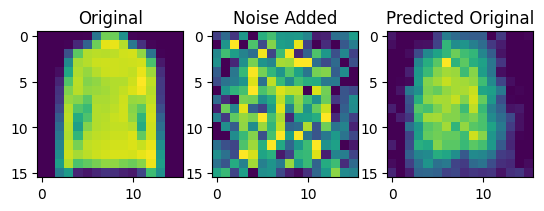

Epoch 0 | Step 200 Loss: 0.07719255983829498 


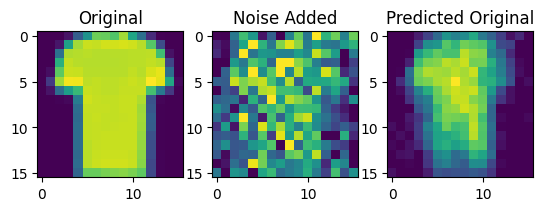

Epoch 0 | Step 300 Loss: 0.06823302060365677 


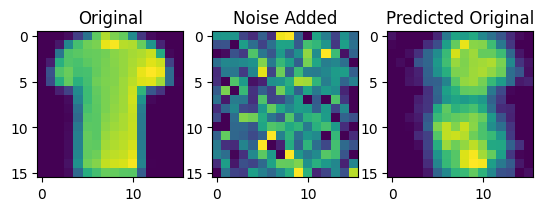

Epoch 0 | Step 400 Loss: 0.06199081614613533 


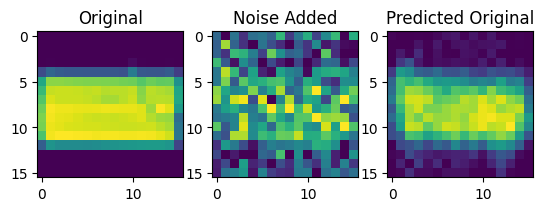

Epoch 0 | Step 500 Loss: 0.05968970060348511 


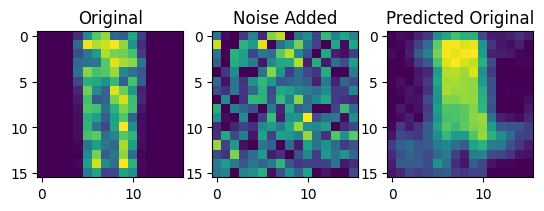

Epoch 1 | Step 000 Loss: 0.05663708969950676 


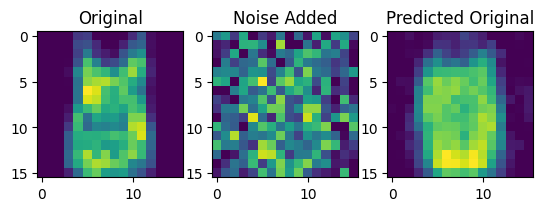

Epoch 1 | Step 100 Loss: 0.056474000215530396 


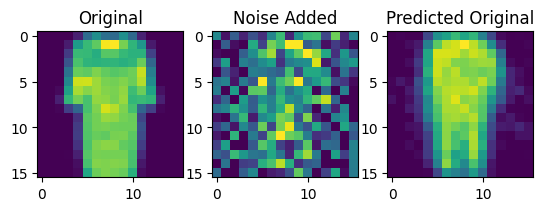

Epoch 1 | Step 200 Loss: 0.054265186190605164 


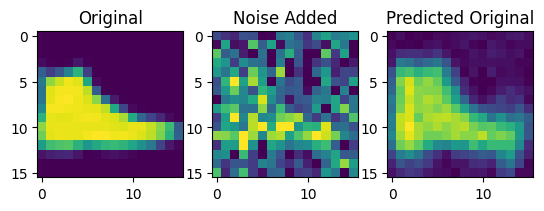

Epoch 1 | Step 300 Loss: 0.051057301461696625 


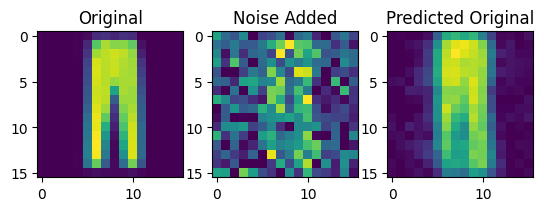

Epoch 1 | Step 400 Loss: 0.05220768600702286 


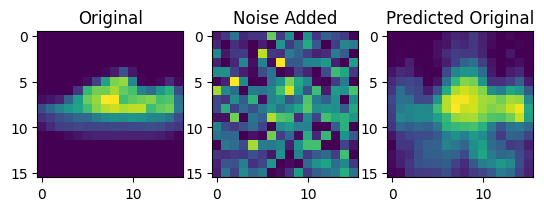

Epoch 1 | Step 500 Loss: 0.04853774979710579 


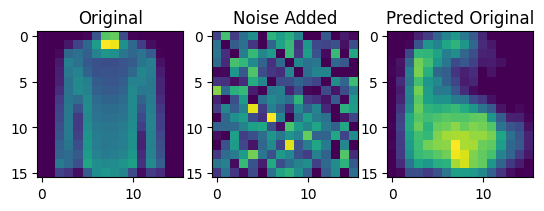

In [32]:
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 2

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        images = batch[0].to(device)
        loss = get_loss(model, images)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")
            plot_sample(images)

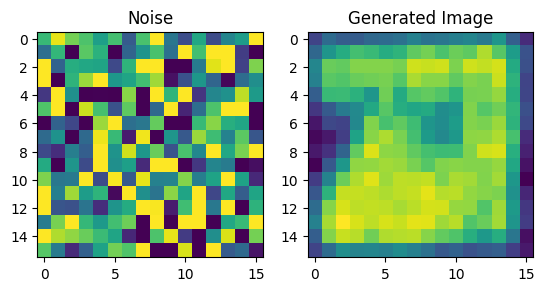

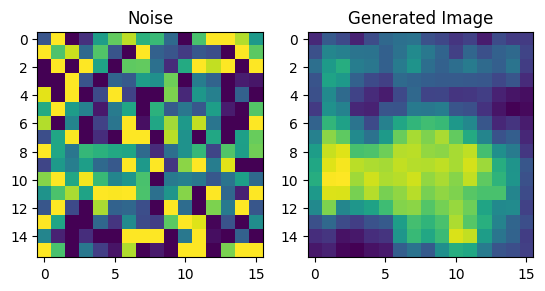

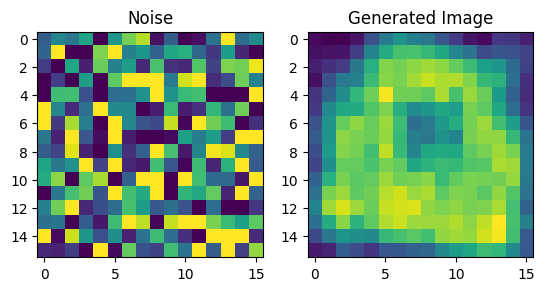

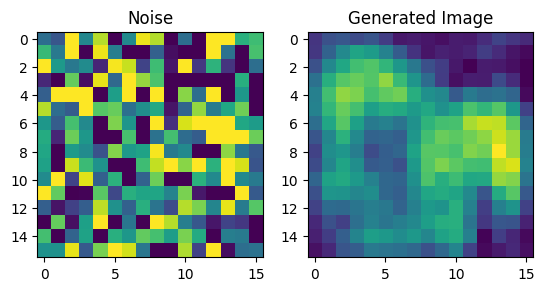

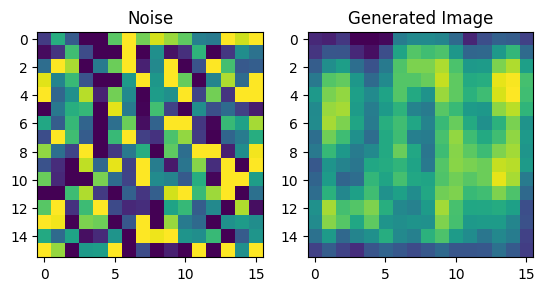

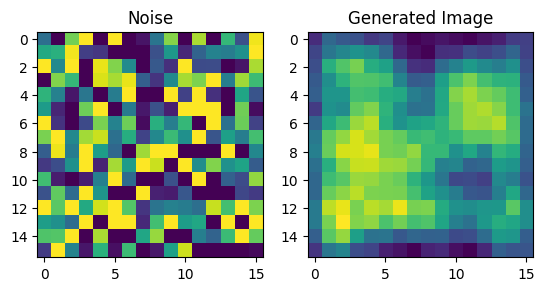

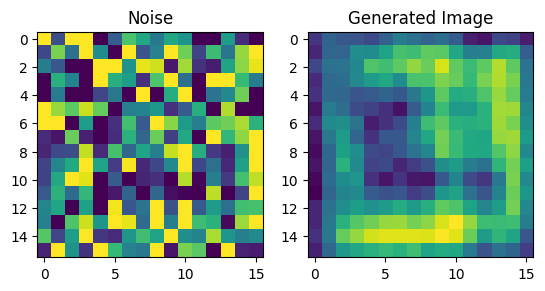

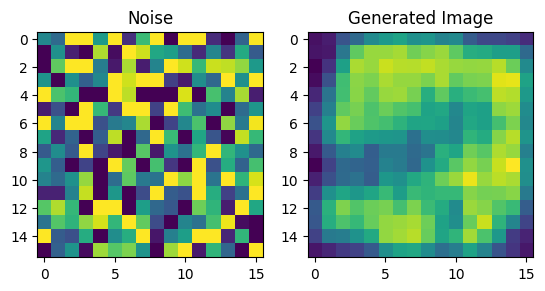

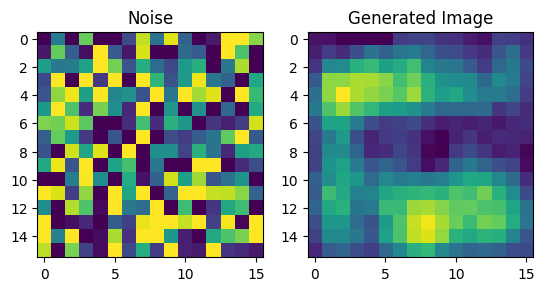

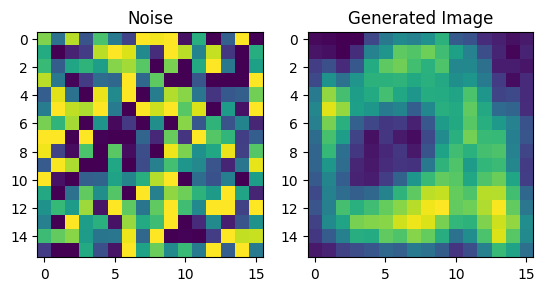

In [33]:
model.eval()
for _ in range(10):
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)
    result = model(noise)
    nrows = 1
    ncols = 2
    samples = {
        "Noise" : noise,
        "Generated Image" : result
    }
    for i, (title, img) in enumerate(samples.items()):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(title)
        show_tensor_image(img)
    plt.show()

In [34]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}